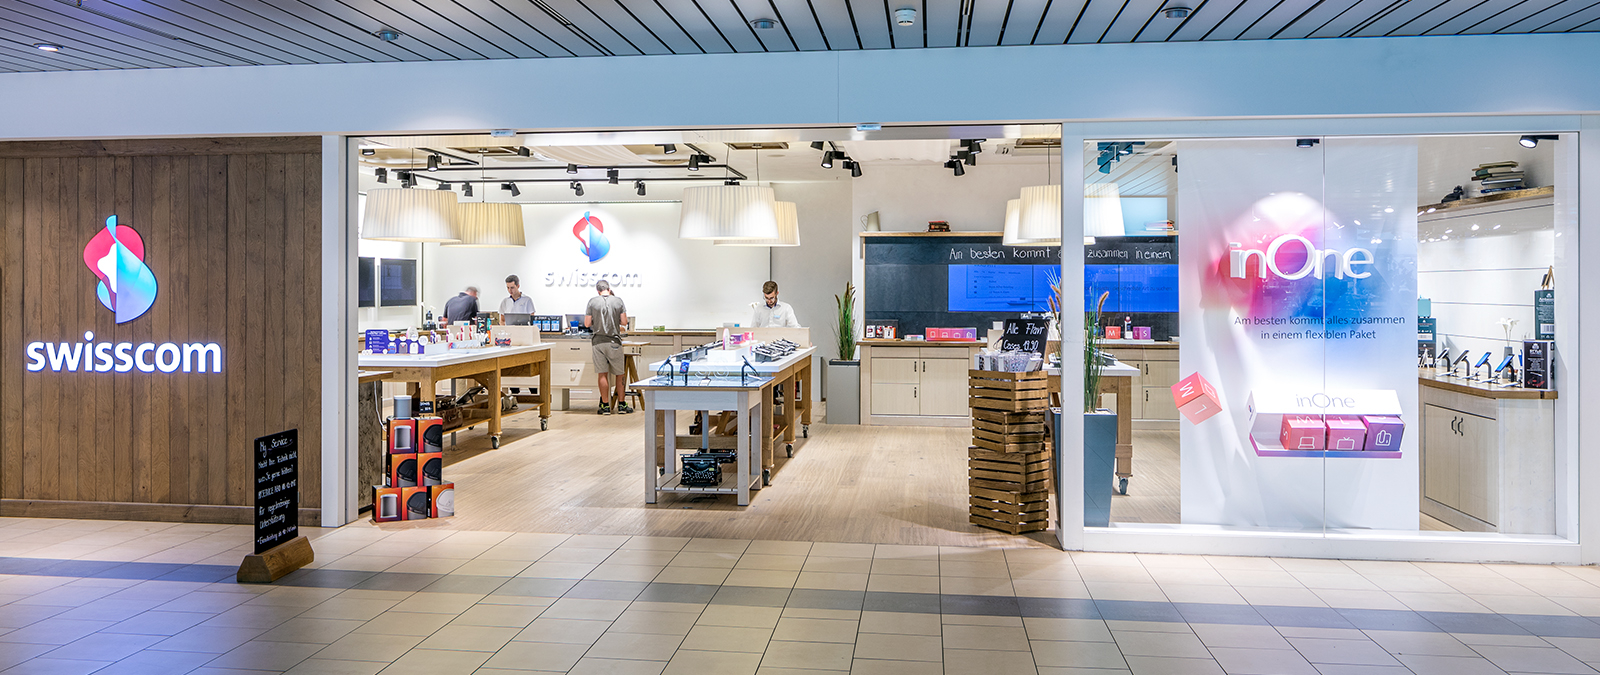

# Swisscom Shops Project

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Requirements-&amp;-Configuration" data-toc-modified-id="Requirements-&amp;-Configuration-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Requirements &amp; Configuration</a></span></li><li><span><a href="#ETL" data-toc-modified-id="ETL-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>ETL</a></span><ul class="toc-item"><li><span><a href="#Remove-all-existing-documents-->-Reset-collection" data-toc-modified-id="Remove-all-existing-documents-->-Reset-collection-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Remove all existing documents -&gt; Reset collection</a></span></li><li><span><a href="#Fetch-data" data-toc-modified-id="Fetch-data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Fetch data</a></span></li><li><span><a href="#Insert-into-MongoDB" data-toc-modified-id="Insert-into-MongoDB-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Insert into MongoDB</a></span></li><li><span><a href="#Transform" data-toc-modified-id="Transform-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Transform</a></span></li><li><span><a href="#Unwind-nested-array" data-toc-modified-id="Unwind-nested-array-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Unwind nested array</a></span><ul class="toc-item"><li><span><a href="#Unwind-using-python" data-toc-modified-id="Unwind-using-python-3.5.1"><span class="toc-item-num">3.5.1&nbsp;&nbsp;</span>Unwind using python</a></span></li><li><span><a href="#Unwind-fields-sub-document-using-pymongo" data-toc-modified-id="Unwind-fields-sub-document-using-pymongo-3.5.2"><span class="toc-item-num">3.5.2&nbsp;&nbsp;</span>Unwind <em>fields</em> sub-document using pymongo</a></span></li></ul></li></ul></li><li><span><a href="#Data-analysis" data-toc-modified-id="Data-analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data analysis</a></span><ul class="toc-item"><li><span><a href="#Shops-per-Canton" data-toc-modified-id="Shops-per-Canton-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Shops per Canton</a></span></li><li><span><a href="#Shops-accessible-for-handycapped-people" data-toc-modified-id="Shops-accessible-for-handycapped-people-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Shops accessible for handycapped people</a></span></li><li><span><a href="#Data-Visualisation" data-toc-modified-id="Data-Visualisation-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Data Visualisation</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusions</a></span><ul class="toc-item"><li><span><a href="#Learnings" data-toc-modified-id="Learnings-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Learnings</a></span></li></ul></li></ul></div>

## Introduction

Swisscom is the leading provider of telecommunication services in Switzerland. It offers a wide range of products and services, including broadband internet, fixed-line telephone service, mobile phone service, digital television and IP-TV. Swisscom also provides IT solutions for businesses as well as cloud computing services. Additionally, it operates 120 retail stores throughout the country where customers can purchase devices such as smartphones, tablets and other products and services.
<a href="https://www.swisscom.ch/en/about.html" target="_blank">https://www.swisscom.ch/en/about.html</a>

<br> <br>

The aim of this report is to demonstrate how to visualise data gathered from the Swisscom Shop API using Python and MongoDB. The [Swisscom Shop](https://data.swisscom.com/explore/dataset/swisscom-shops-de/information/?disjunctive.address_city&disjunctive.address_zip&sort=address_shopname&location=3,26.27104,5.2231 "Open Link") API used for this project can be found on Swisscom in the _Explore_ section. The API contains basic information on Swisscom-owned shops and certified retail partners, these are:
- name
- address
- phone number
- fax
- geographic coordinates for map positioning


Important to know is to define the criteria before one accesses the data. For instance, in the field _row_ change 10 to 120, if not only 10 shops will be accessible with the API. Below the structure of the documents in MongoDB are illustrated. 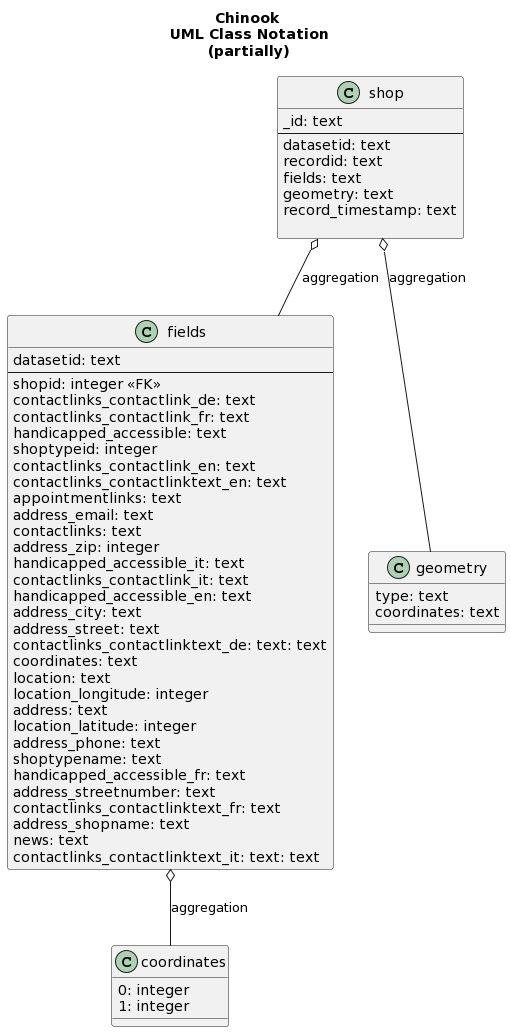






 
The report will start with setting up the connection requirements of the Mongo Database, followed by the ETL process, after that the data will be visualised and a conclusion will end the report.


##  Requirements & Configuration

In [29]:
! pip3 list | findstr "pymongo dnspython pandas"

dnspython                         2.2.1
pandas                            1.5.1
pymongo                           4.3.2


In [30]:
import pymongo
from pprint import pprint
import pandas as pd
import requests
import json

In [31]:
# API and Database details
API_URL = "https://data.swisscom.com/api/records/1.0/search/?dataset=swisscom-shops-de&q=&rows=121&sort=address_shopname&facet=address_city&facet=address_zip"
CNX_STR = "[your cluster]"
DB_NAME = "swisscom"
COLL_NAME = "shop"

In [32]:
# connection to MongoDB
client = pymongo.MongoClient(CNX_STR)
db = client[DB_NAME]
shop = db[COLL_NAME]
dbs = pd.DataFrame(client.list_databases())
dbs

,name,sizeOnDisk,empty
0,genshin,40960,False
1,swisscom,147456,False
2,swisscom_shop,40960,False
3,admin,344064,False
4,local,6690250752,False


## ETL

### Remove all existing documents -> Reset collection

In [33]:
shop.drop()
shop.count_documents({})
#

0

<br> <br>

###  Fetch data

In [34]:
# fetch JSON from API_URL
r = requests.get(API_URL)
data = json.loads(r.text)

In [35]:
print(r.text[0:500])

{"nhits": 6687, "parameters": {"dataset": "swisscom-shops-de", "rows": 121, "start": 0, "sort": ["address_shopname"], "facet": ["address_city", "address_zip"], "format": "json", "timezone": "UTC"}, "records": [{"datasetid": "swisscom-shops-de", "recordid": "c93a94936092144bb1c2082431a570b4ed1ecd05", "fields": {"shopid": 11063, "contactlinks_contactlink_de": "http://www.wattcom.ch", "contactlinks_contactlink_fr": "http://www.wattcom.ch", "handicapped_accessible": "nein", "shoptypeid": 3, "contact


### Insert into MongoDB

In [36]:
# insert the list of shops in "records" into MongoDB collection
shop.insert_many(data['records']);

In [37]:
# count number of documents in shop collection
shop.count_documents({})

121

<br> <br>

In [38]:
# check one document in shop collection
pprint(db.shop.find_one())

{'_id': ObjectId('63a3503d146bf856b2de9a80'),
 'datasetid': 'swisscom-shops-de',
 'fields': {'address': '{}{}',
            'address_city': 'Genève',
            'address_email': '--',
            'address_phone': '+41-22-702 92 62',
            'address_shopname': '1it4u Sàrl',
            'address_street': 'rte de Malagnou',
            'address_streetnumber': '6',
            'address_zip': '1208',
            'appointmentlinks': '{"AppointmentLinkDe": "", '
                                '"AppointmentLinkFr": "", "AppointmentLinkIt": '
                                '"", "AppointmentLinkEn": ""}',
            'contactlinks': '{"ContactLinkDe": "http://www.wattcom.ch", '
                            '"ContactLinkFr": "http://www.wattcom.ch", '
                            '"ContactLinkIt": "http://www.wattcom.ch", '
                            '"ContactLinkEn": "http://www.wattcom.ch", '
                            '"ContactLinkTextDe": "Website öffnen", '
                          

<br> <br>

So, in the output above one can clearly see, that there are sub-documents _fields_ and _geometry_. Apart from that, the output below also confirms the assumption, that those two objects (columns below) hold all important information.

Needless to say the _appointmentlinks_ and _contactlinks_ objects within the _fields_ document are not relevant for this project and therefore, are going to be dropped. 
Although the coordinates are important, they are present three times, once as a _geometry_ sub-document, and twice within the _fields_ sub-document, as a value and another as a _location_ object array.
Once is enough hence only, _location_latitude_ and _location_longitude_ are going to remain.

In [39]:
#Displaying the shop collection in a dataframe to see which "information" is needed
c = shop.aggregate([
      {"$limit": 2},
])

pd.DataFrame(c)

,_id,datasetid,recordid,fields,geometry,record_timestamp
0,63a3503d146bf856b2de9a80,swisscom-shops-de,c93a94936092144bb1c2082431a570b4ed1ecd05,"{'shopid': 11063, 'contactlinks_contactlink_de...","{'type': 'Point', 'coordinates': [6.1573948626...",2022-12-21T04:55:39.346Z
1,63a3503d146bf856b2de9a81,swisscom-shops-de,818d3a46fe155400bc2402c4755b0c86e1cfcd22,"{'shopid': 7774, 'contactlinks_contactlink_de'...","{'type': 'Point', 'coordinates': [8.3075577523...",2022-12-21T04:55:39.346Z


In [40]:
# assign recordid to _id and remove id
c = shop.aggregate([
    {"$project": {"_id": "$recordid", "datasetid": 1, "fields": 1, "geometry": 1, "record_timestamp": 1}},
])
b = pd.DataFrame(c)
b.head(3)

,datasetid,fields,geometry,record_timestamp,_id
0,swisscom-shops-de,"{'shopid': 11063, 'contactlinks_contactlink_de...","{'type': 'Point', 'coordinates': [6.1573948626...",2022-12-21T04:55:39.346Z,c93a94936092144bb1c2082431a570b4ed1ecd05
1,swisscom-shops-de,"{'shopid': 7774, 'contactlinks_contactlink_de'...","{'type': 'Point', 'coordinates': [8.3075577523...",2022-12-21T04:55:39.346Z,818d3a46fe155400bc2402c4755b0c86e1cfcd22
2,swisscom-shops-de,"{'shopid': 11045, 'contactlinks_contactlink_de...","{'type': 'Point', 'coordinates': [6.1445328248...",2022-12-21T04:55:39.346Z,0ec39d41758ff9ac39a74c1d5d1cf7cf0566ebea


<br> <br>

### Transform

As mentioned in the introduction the api contains information on Swisscom-owned shops and certified retail partners. Therefore, a list will be created containing the two different types of shops, this will then be presented in a dataframe to then drop the columns which are not needed.

In [41]:
# Finding Partner Shops nested in shop collection
#for x in shop.find({"fields.shoptypename":"Partner-Shop"}):
    #pprint(x)     

In [42]:
#Finding Shops that are not Partner Shops
#for j in shop.find({"fields.shoptypename":{'$ne':"Partner-Shop"}}):
    #pprint(j)   # so it is "Distributor"

The two loops above find specific shop types and the aggregation below counts the amount of distinct shop types.
As we can see there are three different shop types not two as mentioned in the api information.

In [43]:
#Count and print how distinct shoptypes
cursor = shop.aggregate([
    { '$unwind':'$fields' },
    { '$group':{'_id':'$fields.shoptypename', 'shop_type':{'$sum':1}}},
    { '$sort':{ "_id": 1 } }
]);
b = pd.DataFrame(cursor)
b

,_id,shop_type
0,Distributor,4
1,Partner-Shop,114
2,SC Swisscom Shop,3


### Unwind nested array

#### Unwind using python

First, it was done with python to a dataframe, thanking [Mr Fugu Data Science](https://www.youtube.com/watch?v=FVECTpahzCQ "Link to Video") for providing the video and giving a hint on how the data frame should look like.

In [44]:
# Find and store the 2 different shops in a list
shop_sp = []
for y in shop.find({'$or':[{'fields.shoptypename': 'Distributor'},
                          {'fields.shoptypename': 'Partner-Shop'},
                          {'fields.shoptypename': 'SC Swisscom Shop'}]}) :
    shop_sp.append(y)

# call a news list and iterate through the previous one in order to create the data frame
nested_fields = []
only_ids =[]
for y in shop_sp:
    nested_fields.append(y["fields"])
    only_ids.append(y["_id"])
    
shop_fields = pd.DataFrame(nested_fields)

#add a new column with the id
shop_fields['_id'] = only_ids
shop_fields.head(2)

,shopid,contactlinks_contactlink_de,contactlinks_contactlink_fr,handicapped_accessible,shoptypeid,contactlinks_contactlink_en,contactlinks_contactlinktext_en,appointmentlinks,address_email,contactlinks,...,contactlinks_contactlinktext_fr,address_shopname,news,contactlinks_contactlinktext_it,address_fax,appointmentlinks_appointmentlink_fr,appointmentlinks_appointmentlink_de,appointmentlinks_appointmentlink_it,appointmentlinks_appointmentlink_en,_id
0,11063,http://www.wattcom.ch,http://www.wattcom.ch,nein,3,http://www.wattcom.ch,Open Website,"{""AppointmentLinkDe"": """", ""AppointmentLinkFr"":...",--,"{""ContactLinkDe"": ""http://www.wattcom.ch"", ""Co...",...,Voir le site,1it4u Sàrl,"{""NewsDe"": """", ""NewsFr"": """", ""NewsIt"": """", ""Ne...",Guardare il sito,NaN,NaN,NaN,NaN,NaN,63a3503d146bf856b2de9a80
1,7774,http://www.1solution.ch/,http://www.1solution.ch/,nein,3,http://www.1solution.ch/,Open Website,"{""AppointmentLinkDe"": """", ""AppointmentLinkFr"":...",--,"{""ContactLinkDe"": ""http://www.1solution.ch/"", ...",...,Voir le site,1solution AG,"{""NewsDe"": """", ""NewsFr"": """", ""NewsIt"": """", ""Ne...",Guardare il sito,+41-56-485 76 99,NaN,NaN,NaN,NaN,63a3503d146bf856b2de9a81


In [45]:
#32 columns
#shop_fields.info() 

In [46]:
#Drop multiple columns
shop_fields.drop(['contactlinks_contactlink_de', 'contactlinks_contactlink_fr','contactlinks_contactlink_en',
                 'contactlinks_contactlinktext_en','appointmentlinks','handicapped_accessible_it','contactlinks_contactlink_it',
                 'contactlinks_contactlinktext_de','handicapped_accessible_fr','contactlinks_contactlinktext_it',
                 'contactlinks_contactlinktext_fr',"location",'handicapped_accessible',
                 'address', 'news','address_email', 'contactlinks'], axis = 1, inplace = True)

In [47]:
shop_fields.head(2)

,shopid,shoptypeid,address_zip,handicapped_accessible_en,address_city,address_street,coordinates,location_longitude,location_latitude,address_phone,shoptypename,address_streetnumber,address_shopname,address_fax,appointmentlinks_appointmentlink_fr,appointmentlinks_appointmentlink_de,appointmentlinks_appointmentlink_it,appointmentlinks_appointmentlink_en,_id
0,11063,3,1208,no,Genève,rte de Malagnou,"[46.1984332086195, 6.15739486264927]",6.157395,46.198433,+41-22-702 92 62,Partner-Shop,6,1it4u Sàrl,NaN,NaN,NaN,NaN,NaN,63a3503d146bf856b2de9a80
1,7774,3,5443,no,Niederrohrdorf,Loonstr.,"[47.4234399326177, 8.30755775231435]",8.307558,47.423440,+41-56-485 76 50,Partner-Shop,6A,1solution AG,+41-56-485 76 99,NaN,NaN,NaN,NaN,63a3503d146bf856b2de9a81


The _coordinates_ column will be kept just in case.
Now this dataframe will be saved and uploaded to MongoDB as a new collection called _shopclean_.

In [245]:
#save df to csv
shop_fields.to_csv('shopclean1.csv', index=False, header=True)

In [48]:
#Load csv
data = pd.read_csv('shopclean1.csv')

In [49]:
#Upload the dataframe to mongodb as a new collection
DB_NAME = "swisscom"
COLL_NAME = "shopclean"
shopclean = db[COLL_NAME]

In [50]:
shopclean.drop()
shopclean.count_documents({})

0

In [51]:
data.reset_index(inplace=True)

# Insert collection
data_dict = data.to_dict("records")
shopclean.insert_many(data_dict)

#### Unwind _fields_ sub-document using pymongo

In [52]:
agg_shopfields = shop.aggregate([
    {"$project":{"shopid": "$fields.shopid",
                 "shoptypeid": "$fields.shoptypeid",
                "address_zip": "$fields.address_zip",
                "handicapped_accessible_en": "$fields.handicapped_accessible_en",
                "address_city": "$fields.address_city",
                "address_street": "$fields.address_street",
                "coordinates": "$fields.coordinates",
                "location_longitude": "$fields.location_longitude",
                "location_latitude": "$fields.location_latitude",
                "address_phone" : "$fields.address_phone",
                "shoptypename" : "$fields.shoptypename",
                "address_streetnumber" : "$fields.address_streetnumber",
                "address_shopname": "$fields.address_shopname",
                "address_fax": "$fields.address_fax"     
    }}
]);
pyclean = pd.DataFrame(agg_shopfields)
pyclean.head(4)

,_id,shopid,shoptypeid,address_zip,handicapped_accessible_en,address_city,address_street,coordinates,location_longitude,location_latitude,address_phone,shoptypename,address_streetnumber,address_shopname,address_fax
0,63a3503d146bf856b2de9a80,11063,3,1208,no,Genève,rte de Malagnou,"[46.1984332086195, 6.15739486264927]",6.157395,46.198433,+41-22-702 92 62,Partner-Shop,6,1it4u Sàrl,NaN
1,63a3503d146bf856b2de9a81,7774,3,5443,no,Niederrohrdorf,Loonstr.,"[47.4234399326177, 8.30755775231435]",8.307558,47.423440,+41-56-485 76 50,Partner-Shop,6A,1solution AG,+41-56-485 76 99
2,63a3503d146bf856b2de9a82,11045,3,1205,no,Genève,rue SAINT-OURS,"[46.1977378531502, 6.14453282483435]",6.144533,46.197738,+41-22-752 08 71,Partner-Shop,4,1SWISS1 SA,NaN
3,63a3503d146bf856b2de9a83,7676,3,8966,no,Oberwil-Lieli,Jurastr.,"[47.3419177427353, 8.39218010156182]",8.392180,47.341918,+41-56-633 66 16,Partner-Shop,11,2COM Computer and Communication GmbH,+41-56-633 12 22


In [59]:
#select all rows with NaN values
pyclean[pyclean.isnull().any(axis=1)] #too much information

#_id 63a2dc2c37980972b0c4874e has NaN for coordinates, needs to be droped for data visualisation

In [54]:
#Dropping the row containing NaN value in longitude and latitude
pyclean = pyclean[pyclean.shopid != 7175]

## Data analysis

In this chapter the basic data analysis will be conducted with the _shopclean_ collection.
The data visualisation will be done with the _shop_ collection.

### Shops per Canton

In [55]:
c = shopclean.aggregate([
    {"$project": {"shopclean": 0}},
    {"$group": {"_id": "$address_city", "count": {"$sum": 1}}},
    { "$sort": { "count":-1 }},
 ])

cc = pd.DataFrame(c)
cc.head(6)

,_id,count
0,Zürich,12
1,St. Gallen,5
2,Bern,4
3,Genève,4
4,Winterthur,3
5,Biel/Bienne,3


### Shops accessible for handycapped people

In [56]:
b = shopclean.aggregate([
    {"$project": {"shopclean": 0}},
    {"$group" : {"_id":"$handicapped_accessible_en", "count": {"$sum":1}}},
])

pd.DataFrame(b)

,_id,count
0,yes,5
1,no,116


### Data Visualisation

In [57]:
import folium
from folium import plugins
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
#Use online specific columns
shop_locations = pyclean[["location_latitude", "location_longitude", "shoptypename"]]

#Creating map
map = folium.Map(location=[shop_locations.location_latitude.mean(), shop_locations.location_longitude.mean()],
                 zoom_start=7, control_scale=True)

#Adding points to map
for index, location_info in shop_locations.iterrows():
    folium.Marker([location_info["location_latitude"], location_info["location_longitude"]], 
                  popup=location_info["shoptypename"]).add_to(map)
map

In the canton Graubünden there is only one shop in Chur and it is a Partner-shop which is not a Swisscom shop rather a certified partner.

In [45]:
%%HTML
<style>
/* display:none  -> hide In/Out column */
/* display:block -> show In/Out column */
div.prompt {display:none}
</style>